In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co

import warnings
warnings.filterwarnings("ignore")

In [3]:
import importlib

## Preprocessing
### Read data

In [4]:
data_path = "../../data/probe_Bac_scRNAseq_Rosenthal/B subtilis minimal media"
data_all = sc.read_10x_h5(data_path + "/filtered_feature_bc_matrix.h5")
data_all

AnnData object with n_obs × n_vars = 2784 × 29765
    var: 'gene_ids', 'feature_types', 'genome'

### Aggregate probes through max-pooling

In [5]:
data_maxpool = up.prep_probe_BacSC_data(data_all, agg_fn=np.max)
sc.pp.calculate_qc_metrics(data_maxpool, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_maxpool

Aggregating feature 100/2959
Aggregating feature 200/2959
Aggregating feature 300/2959
Aggregating feature 400/2959
Aggregating feature 500/2959
Aggregating feature 600/2959
Aggregating feature 700/2959
Aggregating feature 800/2959
Aggregating feature 900/2959
Aggregating feature 1000/2959
Aggregating feature 1100/2959
Aggregating feature 1200/2959
Aggregating feature 1300/2959
Aggregating feature 1400/2959
Aggregating feature 1500/2959
Aggregating feature 1600/2959
Aggregating feature 1700/2959
Aggregating feature 1800/2959
Aggregating feature 1900/2959
Aggregating feature 2000/2959
Aggregating feature 2100/2959
Aggregating feature 2200/2959
Aggregating feature 2300/2959
Aggregating feature 2400/2959
Aggregating feature 2500/2959
Aggregating feature 2600/2959
Aggregating feature 2700/2959
Aggregating feature 2800/2959
Aggregating feature 2900/2959


AnnData object with n_obs × n_vars = 2784 × 2959
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [6]:
print(f"Zero inflation of probe-wise data: {((np.prod(data_all.X.shape) - data_all.X.getnnz()) / np.prod(data_all.X.shape)).round(3)}")
print(f"Zero inflation of aggregated data: {((np.prod(data_maxpool.X.shape) - data_maxpool.X.getnnz()) / np.prod(data_maxpool.X.shape)).round(3)}")


Zero inflation of probe-wise data: 0.986
Zero inflation of aggregated data: 0.911


### Filter cells

--> filter based on mean absolute standard deviation

In [7]:
importlib.reload(ut)
data_gene = ut.filter_outliers(data_maxpool, nmads=5, min_cells=2, min_genes=100)
print(data_maxpool.obs.outlier.value_counts())
print(f"Total number of cells: {data_maxpool.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

False    2784
Name: outlier, dtype: int64
Total number of cells: 2784
Number of cells after filtering: 2784


AnnData object with n_obs × n_vars = 2784 × 2952
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

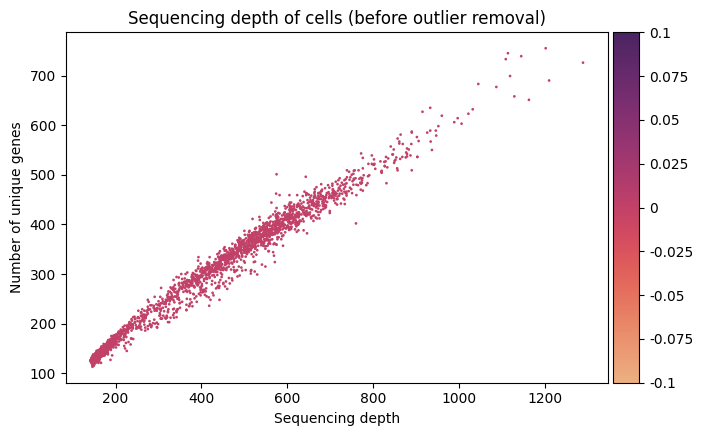

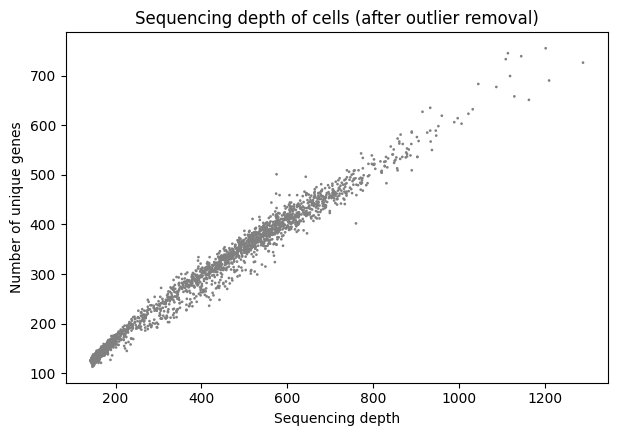

In [8]:
g = sc.pl.scatter(data_maxpool, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="flare", title="Sequencing depth of cells (before outlier removal)")
g.set(xlabel = "Sequencing depth")
g.set(ylabel="Number of unique genes")
plt.tight_layout()
plt.show()

sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15)
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is clearly overdispersed. Therefore, we will use negative binomial count splitting

In [9]:
data_gene.layers["counts"] = data_gene.X.copy()

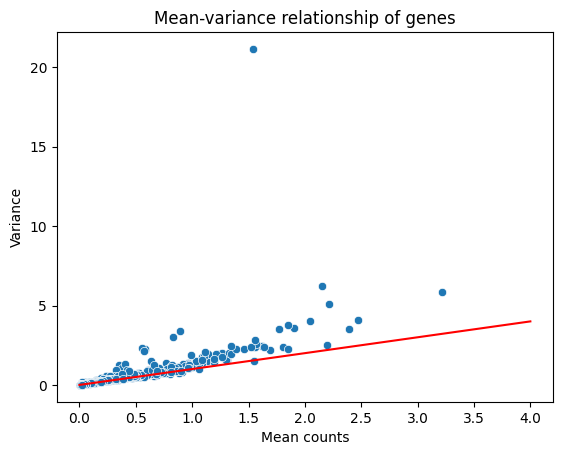

In [10]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.X.toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
plt.title("Mean-variance relationship of genes")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
plt.show()

In [11]:
mv_corr_lin = np.corrcoef(data_gene.var["mean_counts"], data_gene.var["var_counts"])[0,1]
mv_corr_sq = np.corrcoef(data_gene.var["mean_counts"]**2, data_gene.var["var_counts"])[0,1]

if mv_corr_sq > mv_corr_lin:
    is_overdispersed = True
else:
    is_overdispersed = False
    
print(is_overdispersed)

False


## Estimate negative binomial parameters for each gene

In [12]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="sctransform", seed=5678)

In [13]:
data_gene.var

feature_types genome  n_cells_by_counts  mean_counts  \
Sr1   Gene Expression   PA01                 30     0.012931   
aadK  Gene Expression   PA01                163     0.065733   
aag   Gene Expression   PA01                 15     0.006106   
aapA  Gene Expression   PA01                273     0.108118   
abbA  Gene Expression   PA01                308     0.133980   
...               ...    ...                ...          ...   
znuB  Gene Expression   PA01                106     0.042026   
znuC  Gene Expression   PA01                 33     0.013649   
zosA  Gene Expression   PA01                 36     0.015805   
zur   Gene Expression   PA01                 66     0.024784   
zwf   Gene Expression   PA01                894     0.389368   

      log1p_mean_counts  pct_dropout_by_counts  total_counts  \
Sr1            0.012848              98.922414          36.0   
aadK           0.063663              94.145115         183.0   
aag            0.006088              99.461207          17.0   
aapA           0.102663              90.193966         301.0   
abbA           0.125733              88.936782         373.0   
...                 ...                    ...           ...   
znuB           0.041167              96.192529         117.0   
znuC           0.013557              98.814655          38.0   
zosA           0.015681              98.706897          44.0   
zur            0.024482              97.629310          69.0   
zwf            0.328849              67.887931        1084.0   

      log1p_total_counts  n_cells  var_counts  is_scd_outlier  nb_overdisp  \
Sr1             3.610918       30    0.017074           False     0.052334   
aadK            5.214936      163    0.077217           False     0.364663   
aag             2.890372       15    0.007506           False     0.026600   
aapA            5.710427      273    0.117262           False     0.841600   
abbA            5.924256      308    0.173501           False     1.104806   
...                  ...      ...         ...             ...          ...   
znuB            4.770685      106    0.048162           False     0.197193   
znuC            3.663562       33    0.017773           False     0.055566   
zosA            3.806662       36    0.022020           False     0.062456   
zur             4.248495       66    0.026325           False     0.108500   
zwf             6.989335      894    0.400117           False     7.247143   

      nb_overdisp_cutoff   nb_mean    nb_umi  Intercept_step1_sct  \
Sr1             0.052334 -4.500741  0.029095                  NaN   
aadK            0.364663 -7.294739  1.787963            -3.184291   
aag             0.026600 -5.085992 -0.037901                  NaN   
aapA            0.841600 -8.189038  2.329092            -6.187090   
abbA            1.104806 -8.334355  2.451878            -9.582205   
...                  ...       ...       ...                  ...   
znuB            0.197193 -6.144927  1.166694                  NaN   
znuC            0.055566 -4.446236  0.034033                  NaN   
zosA            0.062456 -4.400684  0.067279            -1.751490   
zur             0.108500 -4.804702  0.435957            -6.896310   
zwf             7.247143 -7.989841  2.739687            -7.402585   

      log_umi_step1_sct  dispersion_step1_sct  
Sr1                 NaN                   NaN  
aadK           0.185320              0.050400  
aag                 NaN                   NaN  
aapA           1.560799              0.020054  
abbA           2.934016              0.042674  
...                 ...                   ...  
znuB                NaN                   NaN  
znuC                NaN                   NaN  
zosA          -0.975499              0.106674  
zur            1.264721              0.017477  
zwf            2.514852              0.012294  

[2952 rows x 18 columns]

In [14]:
data_gene.var

feature_types genome  n_cells_by_counts  mean_counts  \
Sr1   Gene Expression   PA01                 30     0.012931   
aadK  Gene Expression   PA01                163     0.065733   
aag   Gene Expression   PA01                 15     0.006106   
aapA  Gene Expression   PA01                273     0.108118   
abbA  Gene Expression   PA01                308     0.133980   
...               ...    ...                ...          ...   
znuB  Gene Expression   PA01                106     0.042026   
znuC  Gene Expression   PA01                 33     0.013649   
zosA  Gene Expression   PA01                 36     0.015805   
zur   Gene Expression   PA01                 66     0.024784   
zwf   Gene Expression   PA01                894     0.389368   

      log1p_mean_counts  pct_dropout_by_counts  total_counts  \
Sr1            0.012848              98.922414          36.0   
aadK           0.063663              94.145115         183.0   
aag            0.006088              99.461207          17.0   
aapA           0.102663              90.193966         301.0   
abbA           0.125733              88.936782         373.0   
...                 ...                    ...           ...   
znuB           0.041167              96.192529         117.0   
znuC           0.013557              98.814655          38.0   
zosA           0.015681              98.706897          44.0   
zur            0.024482              97.629310          69.0   
zwf            0.328849              67.887931        1084.0   

      log1p_total_counts  n_cells  var_counts  is_scd_outlier  nb_overdisp  \
Sr1             3.610918       30    0.017074           False     0.052334   
aadK            5.214936      163    0.077217           False     0.364663   
aag             2.890372       15    0.007506           False     0.026600   
aapA            5.710427      273    0.117262           False     0.841600   
abbA            5.924256      308    0.173501           False     1.104806   
...                  ...      ...         ...             ...          ...   
znuB            4.770685      106    0.048162           False     0.197193   
znuC            3.663562       33    0.017773           False     0.055566   
zosA            3.806662       36    0.022020           False     0.062456   
zur             4.248495       66    0.026325           False     0.108500   
zwf             6.989335      894    0.400117           False     7.247143   

      nb_overdisp_cutoff   nb_mean    nb_umi  Intercept_step1_sct  \
Sr1             0.052334 -4.500741  0.029095                  NaN   
aadK            0.364663 -7.294739  1.787963            -3.184291   
aag             0.026600 -5.085992 -0.037901                  NaN   
aapA            0.841600 -8.189038  2.329092            -6.187090   
abbA            1.104806 -8.334355  2.451878            -9.582205   
...                  ...       ...       ...                  ...   
znuB            0.197193 -6.144927  1.166694                  NaN   
znuC            0.055566 -4.446236  0.034033                  NaN   
zosA            0.062456 -4.400684  0.067279            -1.751490   
zur             0.108500 -4.804702  0.435957            -6.896310   
zwf             7.247143 -7.989841  2.739687            -7.402585   

      log_umi_step1_sct  dispersion_step1_sct  
Sr1                 NaN                   NaN  
aadK           0.185320              0.050400  
aag                 NaN                   NaN  
aapA           1.560799              0.020054  
abbA           2.934016              0.042674  
...                 ...                   ...  
znuB                NaN                   NaN  
znuC                NaN                   NaN  
zosA          -0.975499              0.106674  
zur            1.264721              0.017477  
zwf            2.514852              0.012294  

[2952 rows x 18 columns]

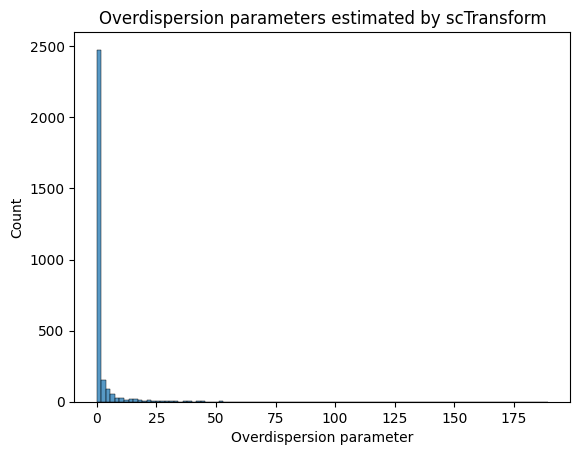

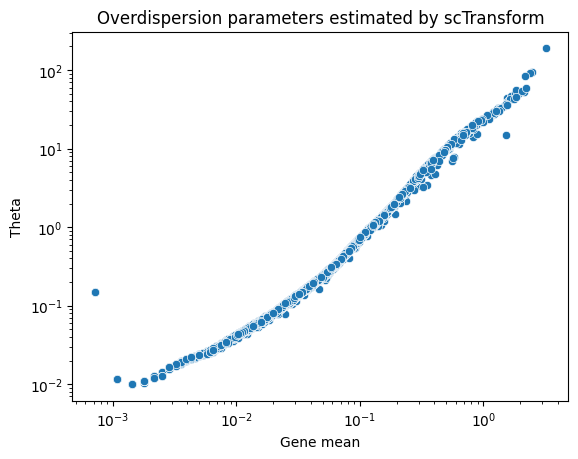

In [15]:
sns.histplot(data=data_gene.var, x="nb_overdisp_cutoff", bins=100)
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Overdispersion parameter")
plt.show()

g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log", yscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

In [16]:
data_gene.X = data_gene.layers["counts"].copy()

## Normalization, VST, scaling and PCA

In [17]:
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)
if is_overdispersed:
    data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_gene.X = sps.csr_matrix(np.sqrt(data_gene.X.toarray()))
    data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))

data_gene.layers["vst_counts"] = data_gene.X.copy()
sc.pp.scale(data_gene, max_value=10, zero_center=True)
# data_gene.X[np.isnan(data_gene.X)] = 0
sc.tl.pca(data_gene, svd_solver='arpack')

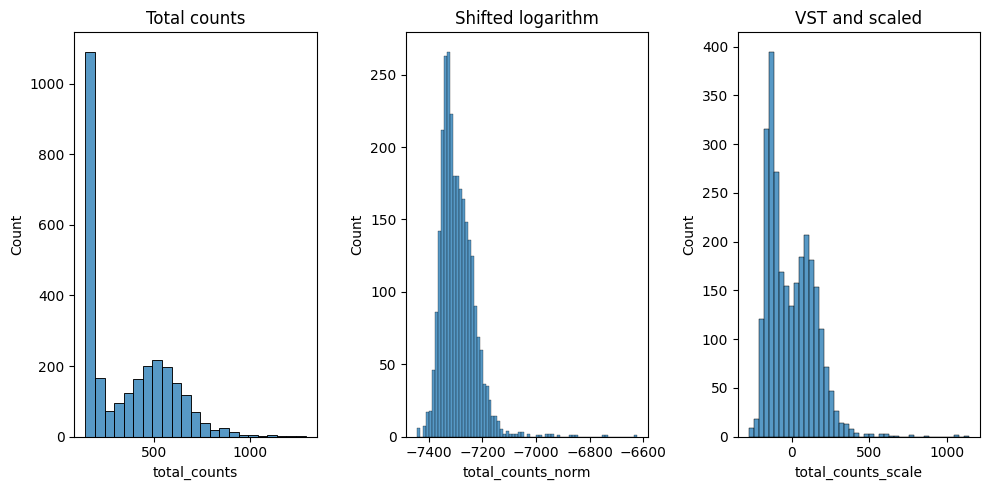

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.tight_layout()
plt.show()

## Count-splitting into train and test data

In [19]:
if is_overdispersed:
    data_dist = "NB"
else:
    data_dist = "Poi"
data_train, data_test = cs.countsplit_adata(data_gene, data_dist=data_dist, beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)
print(data_train)

AnnData object with n_obs × n_vars = 2784 × 2929
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    layers: 'counts'


In [20]:
# Transformation, centering and PCA
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
if is_overdispersed:
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_train.X = sps.csr_matrix(np.sqrt(data_train.X.toarray()))
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
if is_overdispersed:
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_test.X = sps.csr_matrix(np.sqrt(data_test.X.toarray()))
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
sc.tl.pca(data_test, svd_solver='arpack')

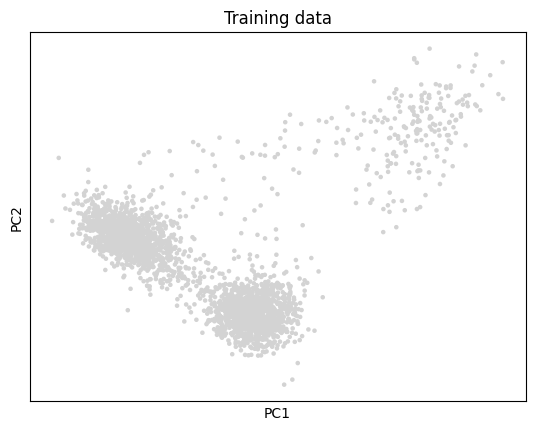

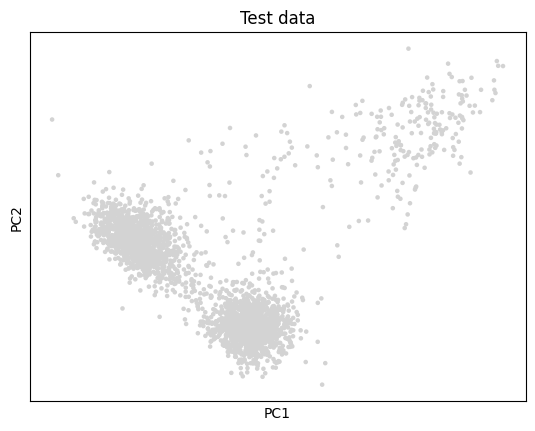

In [21]:
sc.pl.pca(data_train, title="Training data")
plt.show()

sc.pl.pca(data_test, title="Test data")
plt.show()

### Principal component selection

In [22]:
k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")

Optimal number of PCs:4


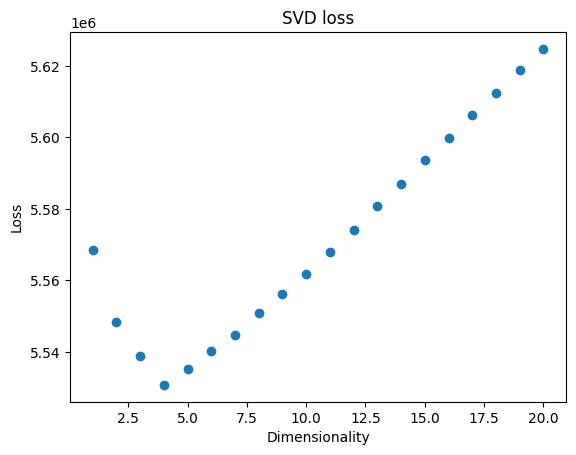

In [23]:
plt.scatter(np.arange(20) + 1, k_errors)
plt.title("SVD loss")
plt.xlabel("Dimensionality")
plt.ylabel("Loss")
plt.show()

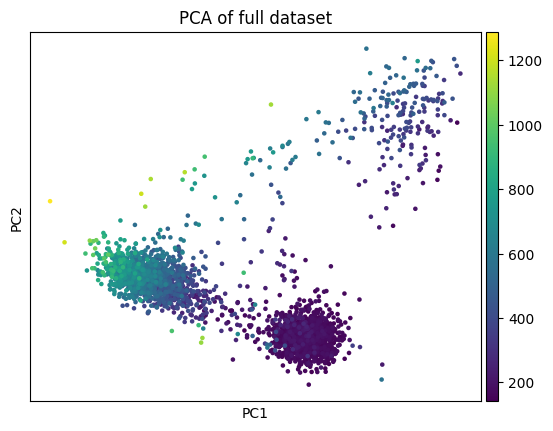

In [24]:
sc.pl.pca(data_gene, color="total_counts", cmap="viridis", title="PCA of full dataset")
plt.show()

In [25]:
data_gene.uns["BacSC_params"] = {"k_opt": k_opt}

## Selection of optimal number of neighbors and optimal UMAP scale via scDEED

In [25]:
rng = np.random.default_rng()
seed = rng.choice(1000)
print(seed)

140


In [26]:
importlib.reload(scd)

n_neighborss = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250]
min_dists = [0.05, 0.1, 0.3, 0.5, 0.7]

scdeed_result, rel_scores, null_rel_scores, reliabilities, n_neighbors_opt, min_dist_opt = scd.scdeed_parameter_selection(data_gene, n_neighborss, min_dists, n_pcs=k_opt, rng_seed=seed, embedding_method="UMAP", similarity_percent=0.5, save_path="Bsub_minmed_scdeed")

calculating (10, 0.05) - run 1/85
calculating (10, 0.1) - run 2/85
calculating (10, 0.3) - run 3/85
calculating (10, 0.5) - run 4/85
calculating (10, 0.7) - run 5/85
calculating (15, 0.05) - run 6/85
calculating (15, 0.1) - run 7/85
calculating (15, 0.3) - run 8/85
calculating (15, 0.5) - run 9/85
calculating (15, 0.7) - run 10/85
calculating (20, 0.05) - run 11/85
calculating (20, 0.1) - run 12/85
calculating (20, 0.3) - run 13/85
calculating (20, 0.5) - run 14/85
calculating (20, 0.7) - run 15/85
calculating (25, 0.05) - run 16/85
calculating (25, 0.1) - run 17/85
calculating (25, 0.3) - run 18/85
calculating (25, 0.5) - run 19/85
calculating (25, 0.7) - run 20/85
calculating (30, 0.05) - run 21/85
calculating (30, 0.1) - run 22/85
calculating (30, 0.3) - run 23/85
calculating (30, 0.5) - run 24/85
calculating (30, 0.7) - run 25/85
calculating (35, 0.05) - run 26/85
calculating (35, 0.1) - run 27/85
calculating (35, 0.3) - run 28/85
calculating (35, 0.5) - run 29/85
calculating (35, 

Optimal number of neighbors: 20
Optimal min_dist: 0.5


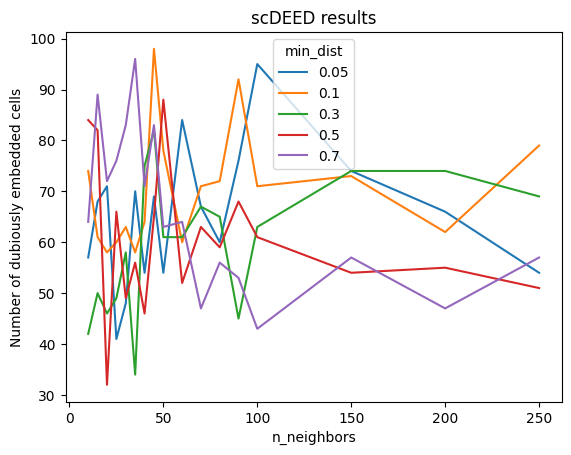

In [27]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(data=scdeed_result, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10")
plt.title("scDEED results")
plt.ylabel("Number of dubiously embedded cells")
plt.show()

In [26]:
# k_opt = data_gene.uns["BacSC_params"]["k_opt"]
# n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
# min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]


k_opt = 4
n_neighbors_opt = 20
min_dist_opt = 0.5

In [27]:
data_gene.uns["BacSC_params"]["n_neighbors_opt"] = n_neighbors_opt
data_gene.uns["BacSC_params"]["min_dist_opt"] = min_dist_opt

In [28]:
sc.pp.neighbors(data_gene, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_gene, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=3456)


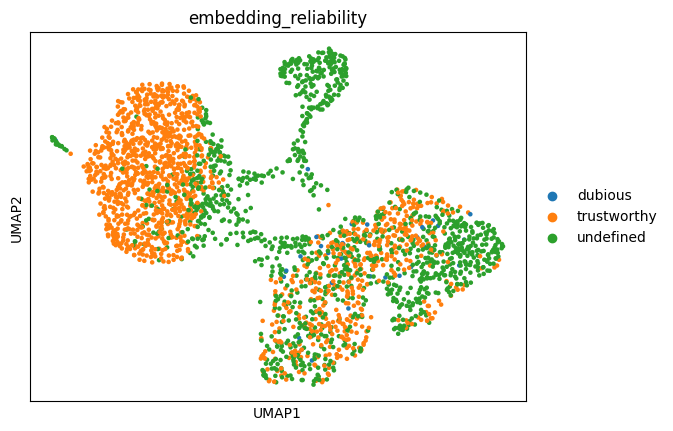

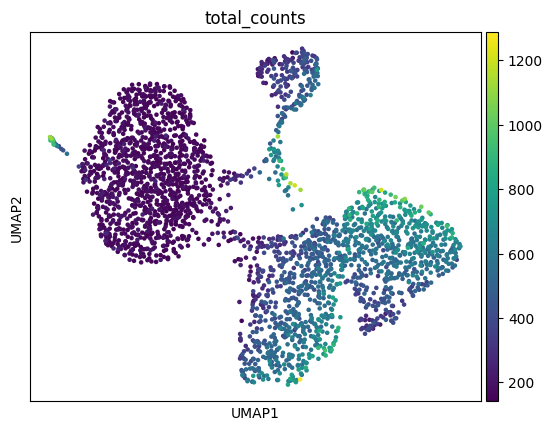

In [31]:
sc.pl.umap(data_gene, color="embedding_reliability", alpha=1)
plt.show()

sc.pl.umap(data_gene, color="total_counts", alpha=1, cmap="viridis")
plt.show()

In [50]:
data_gene.write(data_path + "/filtered_data_maxpool_processed.h5ad")


## Clustering

### Train/test-split for clustering

In [51]:
sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_train, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)

sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_test, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)


theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy())
data_test.obsm["X_umap_rot"] = umap_2_opt

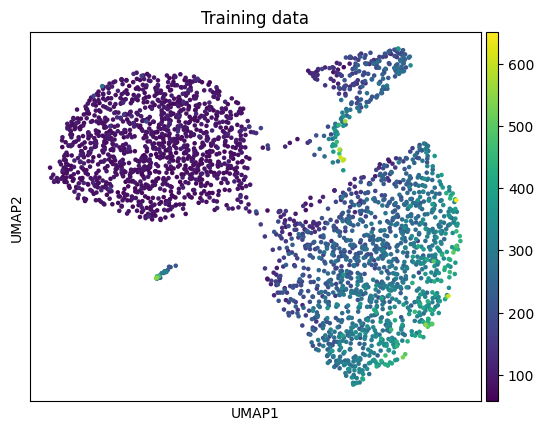

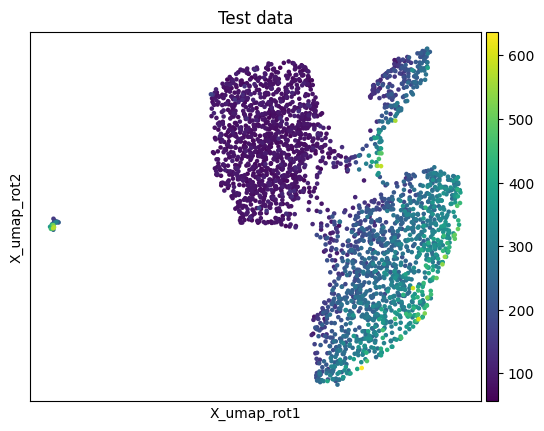

In [52]:
sc.pl.umap(data_train, color="total_counts", cmap="viridis", title="Training data")
plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color="total_counts", cmap="viridis", title="Test data")
plt.show()

### Apply clustering with array of resolutions

In [53]:
importlib.reload(co)
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

co.cluster_train_test(data_train, data_test, resolutions, alg="leiden")

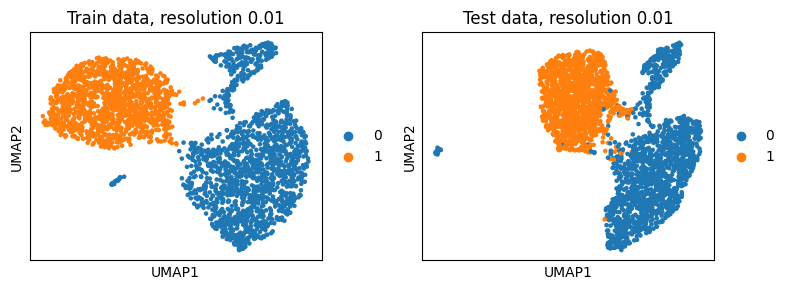

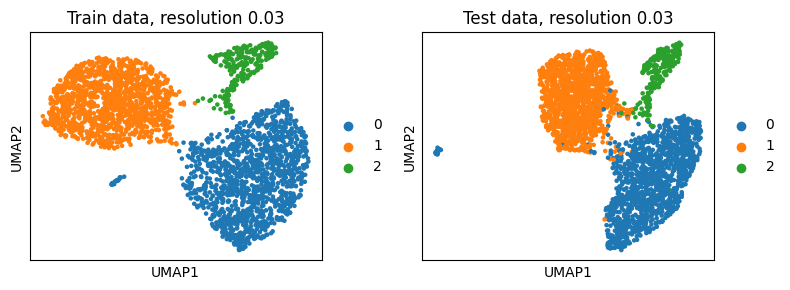

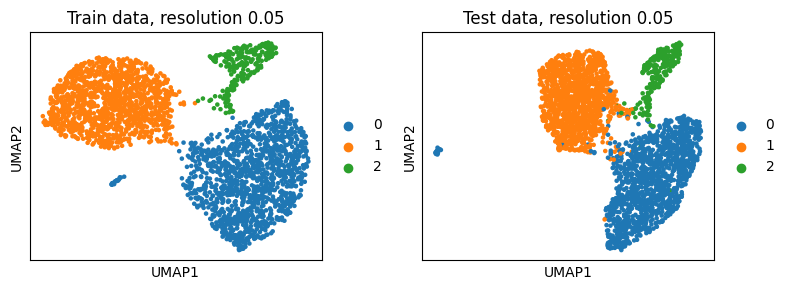

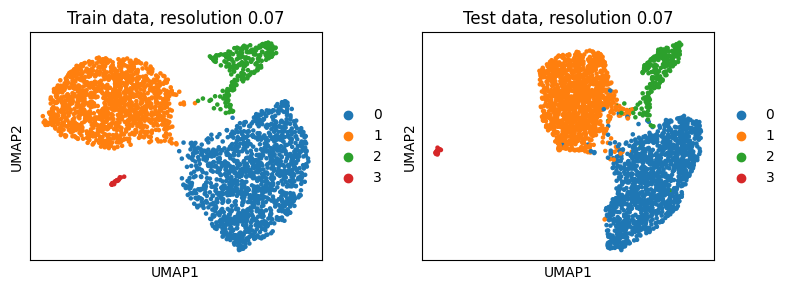

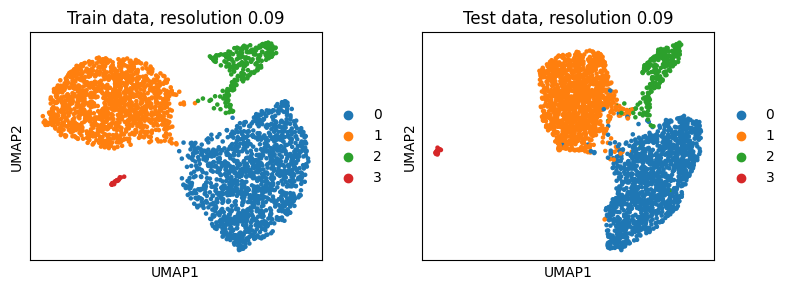

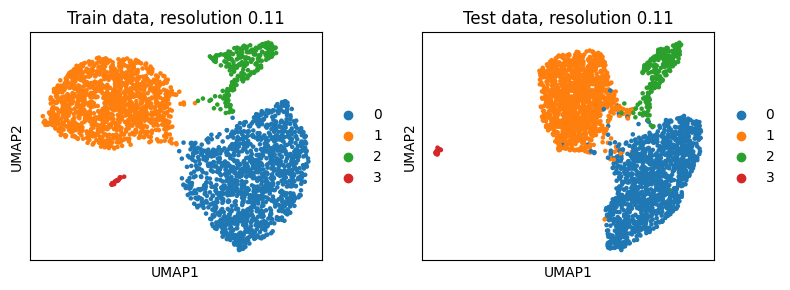

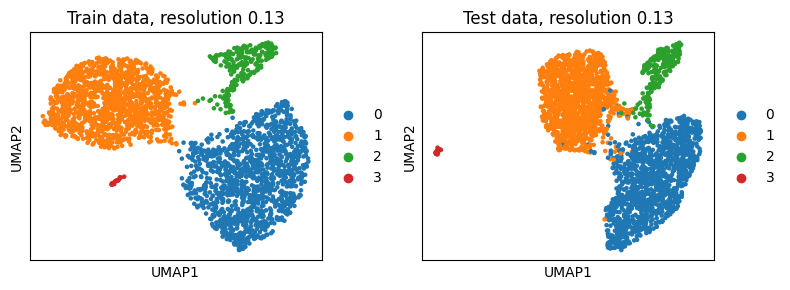

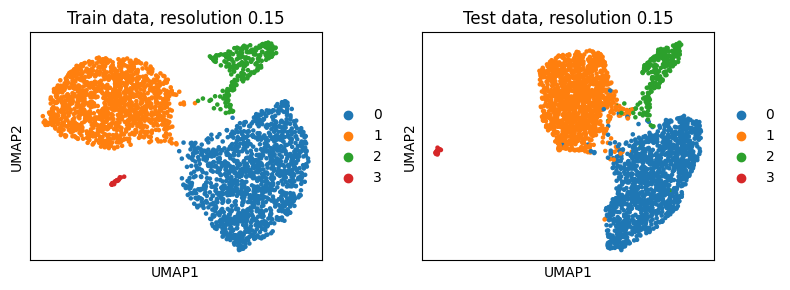

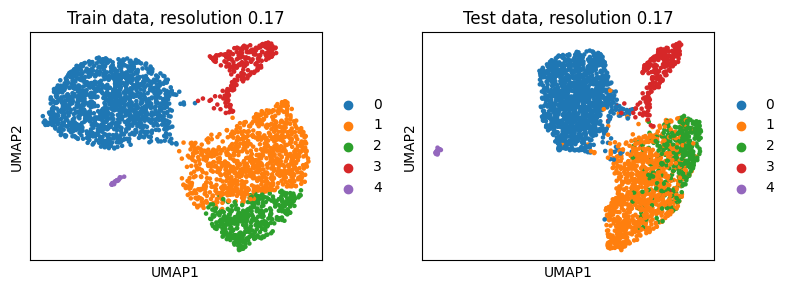

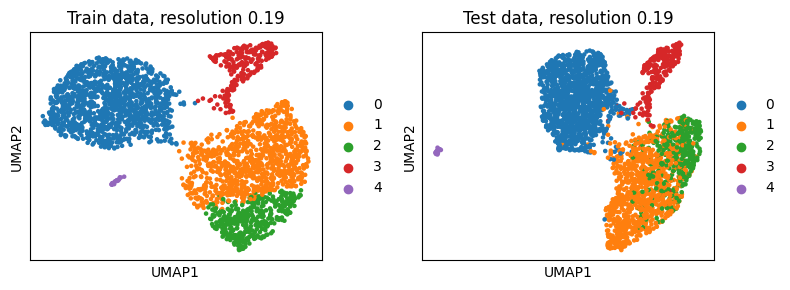

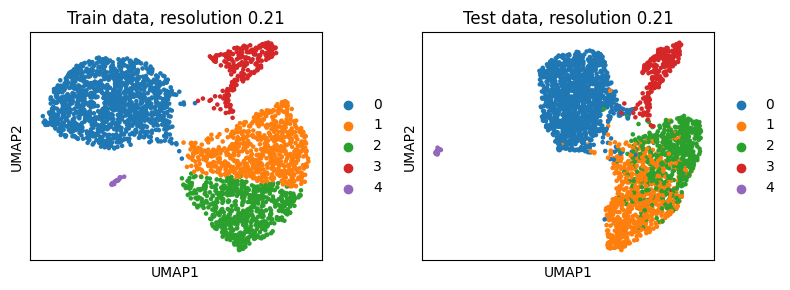

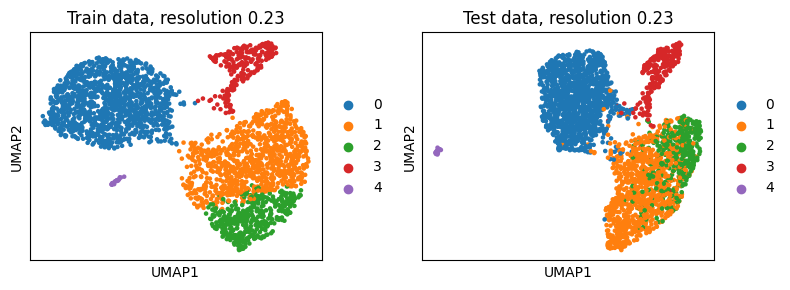

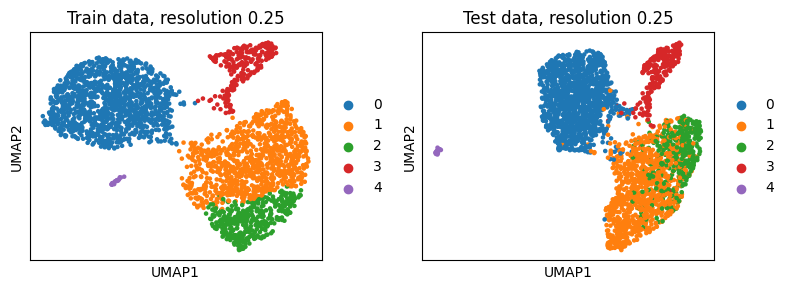

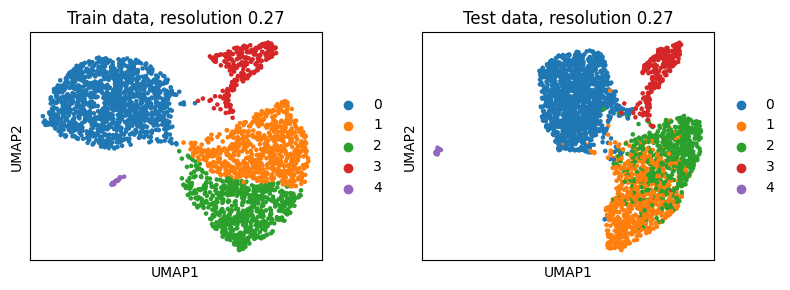

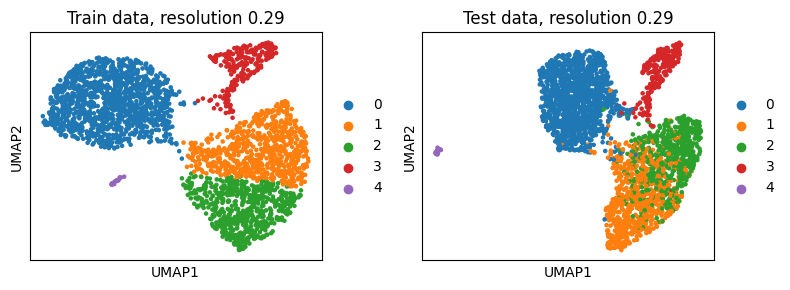

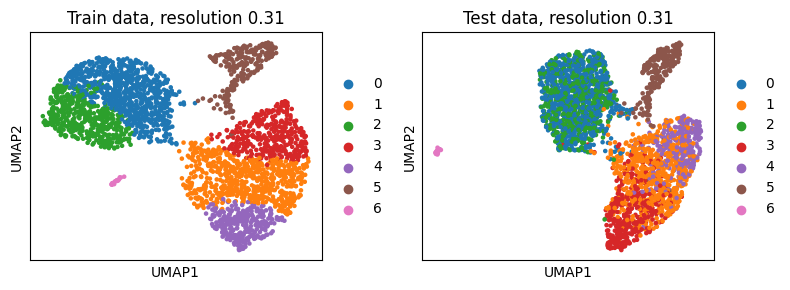

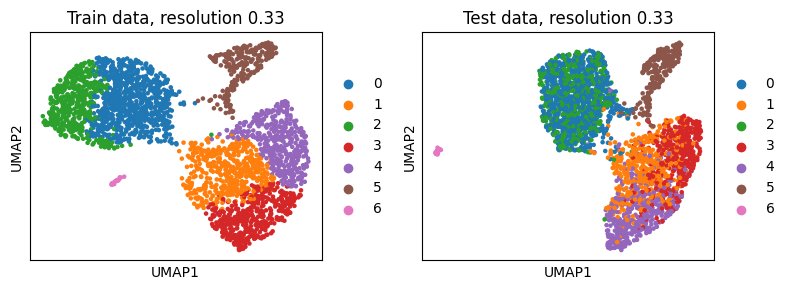

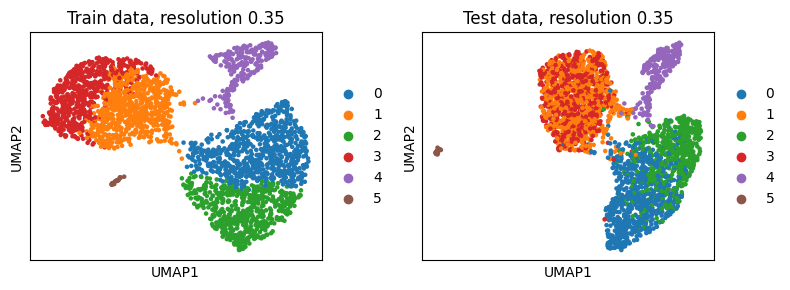

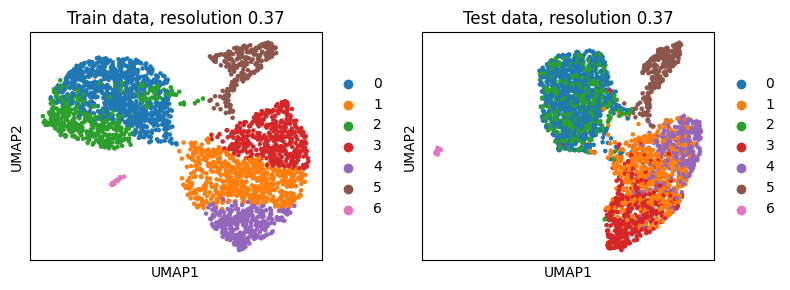

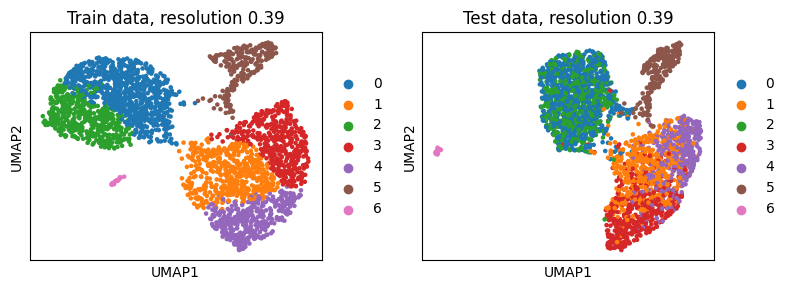

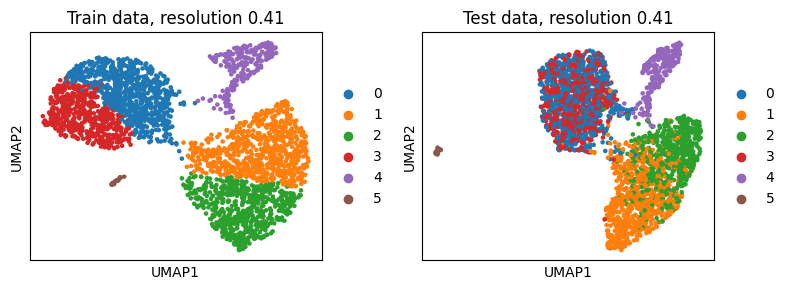

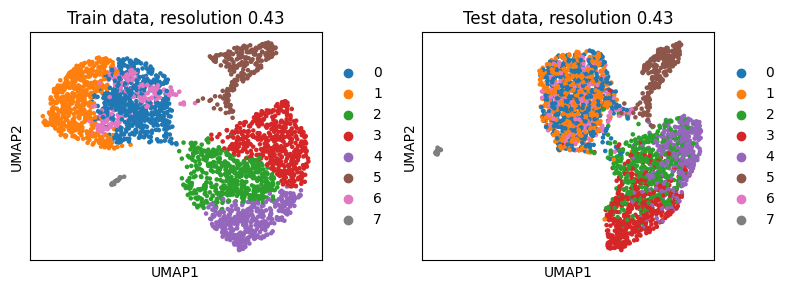

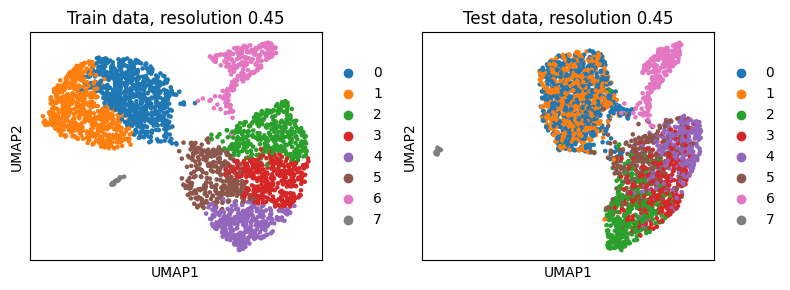

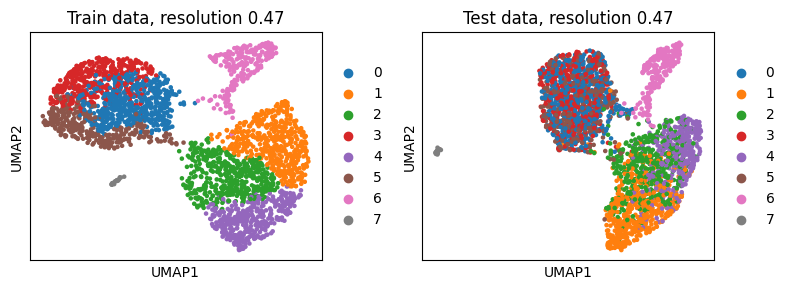

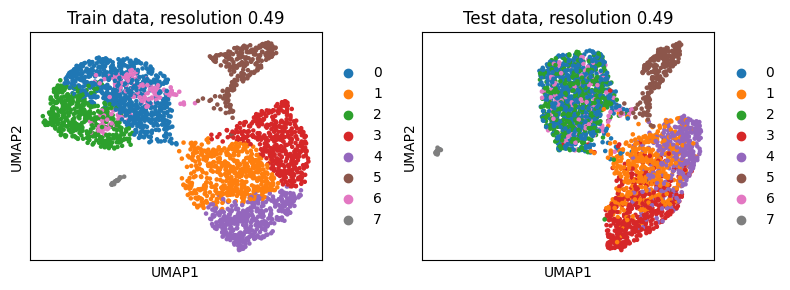

In [54]:
for resolution in resolutions:
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    sc.pl.umap(data_train, color=f"leiden_res{resolution}", ax=ax[0], title=f"Train data, resolution {resolution}", show=False)
    sc.pl.embedding(data_test, basis="X_umap_rot", color=f"leiden_res{resolution}", ax=ax[1], title=f"Test data, resolution {resolution}", show=False)
    ax[1].set_xlabel("UMAP1")
    ax[1].set_ylabel("UMAP2")
    plt.tight_layout()
    plt.show()

Modularities

In [55]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(data_train, data_test, resolutions)

print(f"Optimal resolution {res_opt}")
data_gene.uns["BacSC_params"]["res_opt"] = res_opt


resolution: 0.01 - clusters: 2 - Train: 0.492 - Test: 0.487 - Random: 0.247
resolution: 0.03 - clusters: 3 - Train: 0.482 - Test: 0.477 - Random: 0.198
resolution: 0.05 - clusters: 3 - Train: 0.474 - Test: 0.468 - Random: 0.19
resolution: 0.07 - clusters: 4 - Train: 0.465 - Test: 0.46 - Random: 0.184
resolution: 0.09 - clusters: 4 - Train: 0.457 - Test: 0.452 - Random: 0.172
resolution: 0.11 - clusters: 4 - Train: 0.449 - Test: 0.443 - Random: 0.163
resolution: 0.13 - clusters: 4 - Train: 0.44 - Test: 0.435 - Random: 0.157
resolution: 0.15 - clusters: 4 - Train: 0.432 - Test: 0.426 - Random: 0.144
resolution: 0.17 - clusters: 5 - Train: 0.428 - Test: 0.378 - Random: 0.109
resolution: 0.19 - clusters: 5 - Train: 0.421 - Test: 0.372 - Random: 0.103
resolution: 0.21 - clusters: 5 - Train: 0.418 - Test: 0.364 - Random: 0.089
resolution: 0.23 - clusters: 5 - Train: 0.408 - Test: 0.357 - Random: 0.086
resolution: 0.25 - clusters: 5 - Train: 0.401 - Test: 0.352 - Random: 0.081
resolution: 0.2

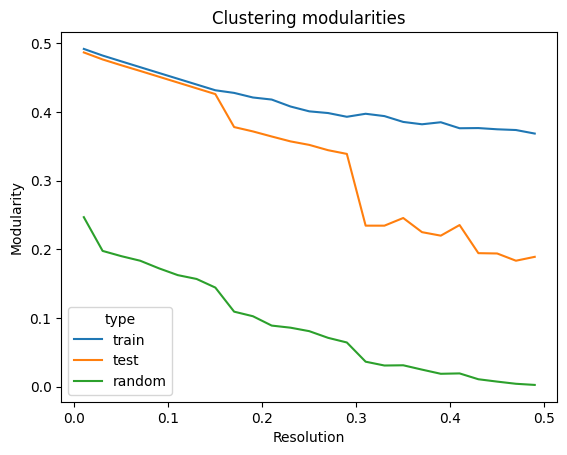

In [56]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Modularity")
plt.show()

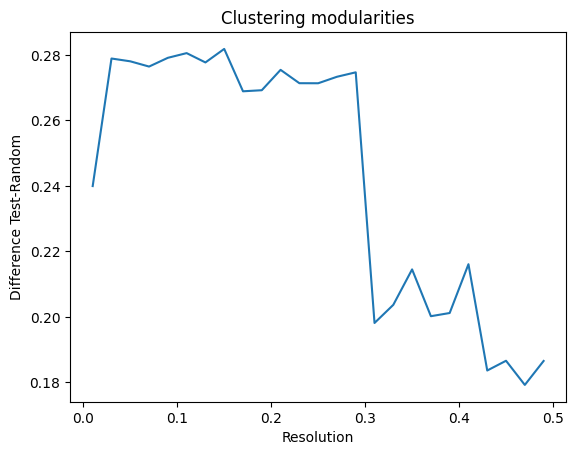

In [57]:
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Difference Test-Random")
plt.show()

## Cluster analysis

Optimal Leiden resolution: Maximal difference between random and test

In [58]:
sc.tl.leiden(data_gene, resolution=res_opt, key_added="leiden_opt")

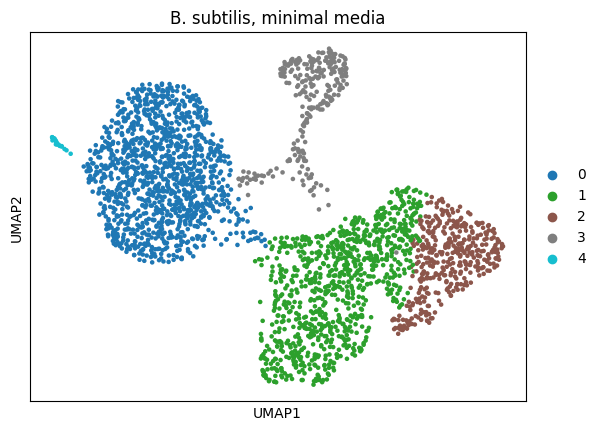

In [49]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="B. subtilis, minimal media")
plt.show()

In [60]:
data_gene.write(data_path + "/filtered_data_maxpool_processed.h5ad")

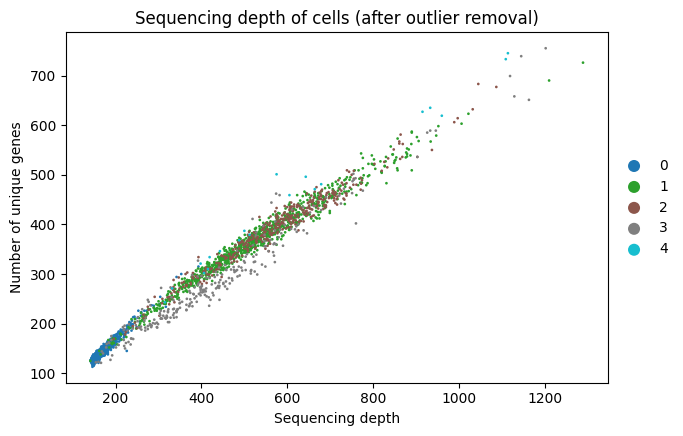

In [61]:
sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="leiden_opt")
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

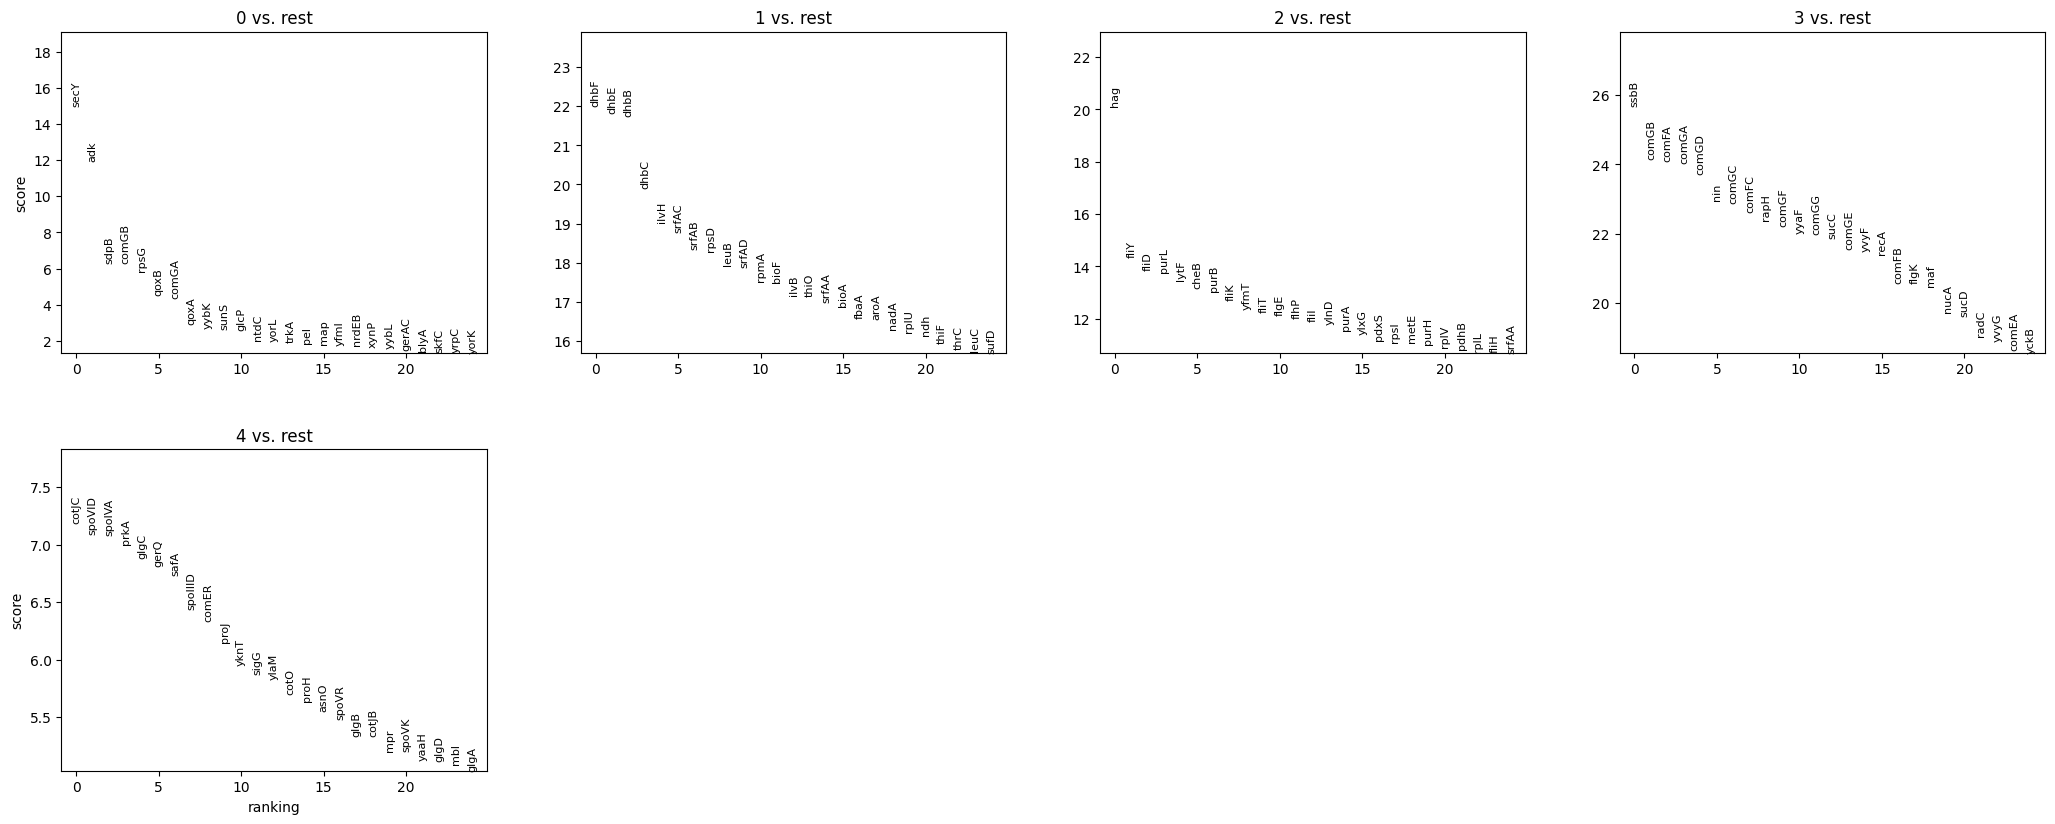

In [62]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

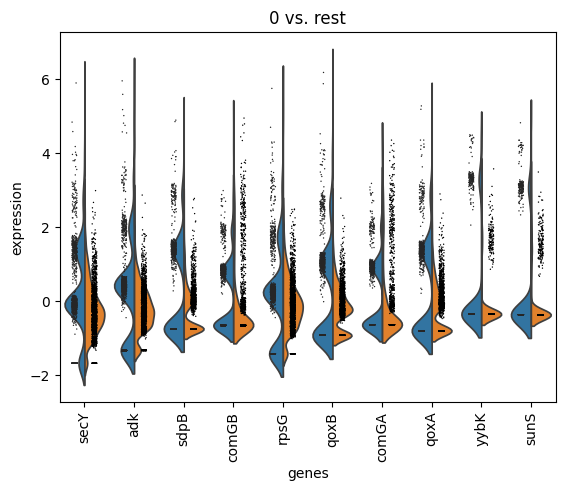

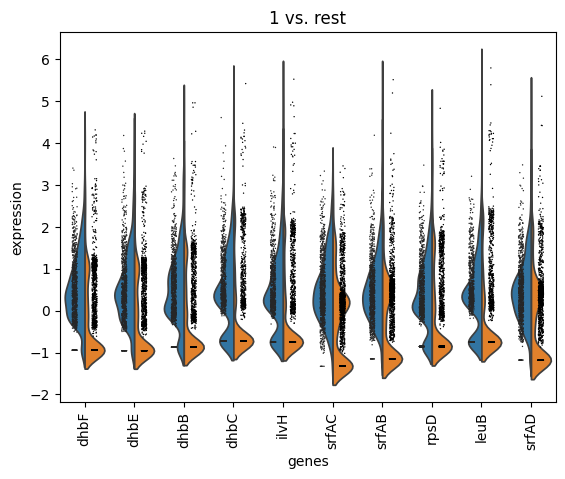

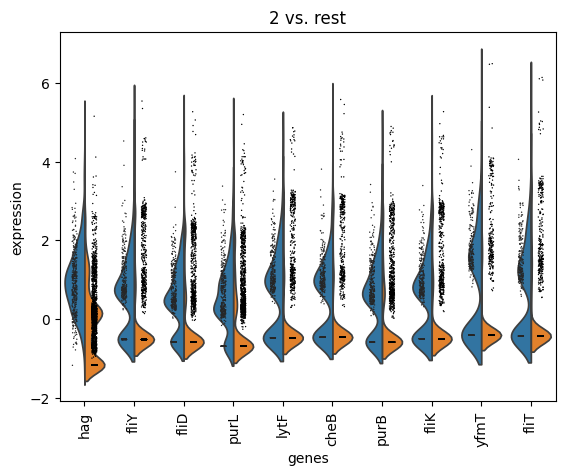

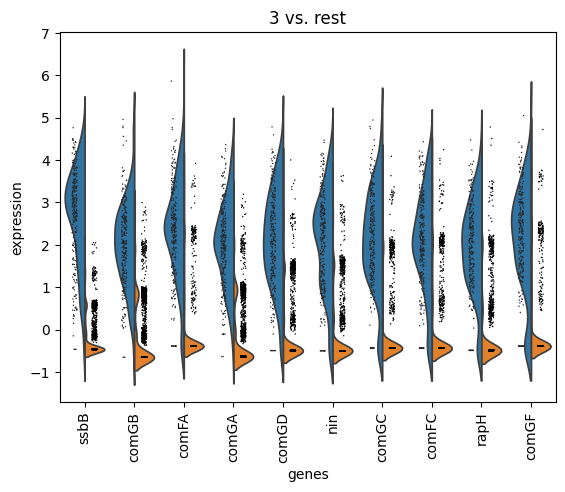

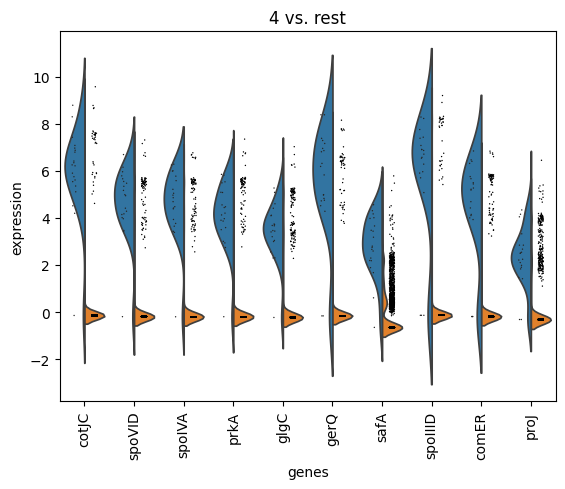

In [63]:
nclust = len(np.unique(data_gene.obs["leiden_opt"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(data_gene, groups=str(i), n_genes=10)

## Attach feature table

In [9]:
data_path = "../../data/probe_Bac_scRNAseq_Rosenthal/B subtilis minimal media"
data_gene = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed.h5ad")
data_gene

AnnData object with n_obs × n_vars = 2784 × 2952
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    uns: 'BacSC_params', 'embedding_reliability_colors', 'leiden_opt', 'leiden_opt_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'connectivities', 'distances'

In [10]:
feature_table = pd.read_csv("../../data/probe_Bac_scRNAseq_Rosenthal/B_subtilis_168_feature_table.tsv", sep="\t")
feature_table = feature_table[["Locus tag", "Protein accession", "Name", "Symbol"]]

feature_table

Locus tag Protein accession  \
0     BSU_00010       NP_387882.1   
1     BSU_00020       NP_387883.1   
2     BSU_00030       NP_387884.1   
3     BSU_00040       NP_387885.1   
4     BSU_00050       NP_387886.2   
...         ...               ...   
4531  BSU_41020       NP_391982.1   
4532  BSU_41030       NP_391983.1   
4533  BSU_41040       NP_391984.1   
4534  BSU_41050       NP_391985.1   
4535  BSU_41060       NP_391986.1   

                                                   Name Symbol  
0     chromosomal replication initiator informationa...   dnaA  
1                     DNA polymerase III (beta subunit)   dnaN  
2     RNA binding protein involved in ribosome matur...   rlbA  
3     RecA filament-DNA complex stabilisation, ssDNA...   recF  
4           regulator of extracellular matrix formation   remB  
...                                                 ...    ...  
4531  tRNA modification GTPase and tRNA-U34 5-formyl...   mnmE  
4532       SpoIIIJ-associated RNA/ssDNA-binding protein    jag  
4533  Sec-independent factor for membrane protein in...  oxaAA  
4534  protein component of ribonuclease P (RNase P) ...   rnpA  
4535                              ribosomal protein L34   rpmH  

[4536 rows x 4 columns]

In [11]:
df3=data_gene.var.reset_index().merge(feature_table, how='left', left_on='index', right_on='Symbol').drop_duplicates("index").set_index("index")
data_gene.var = df3

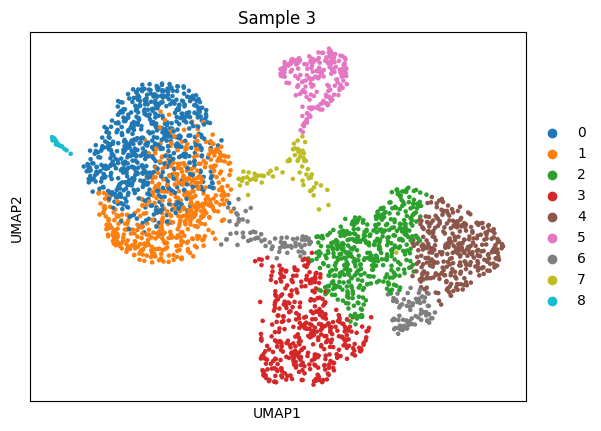

In [29]:
sc.tl.leiden(data_gene, resolution=0.45, key_added="leiden_new")
sc.pl.umap(data_gene, color="leiden_new", palette="tab10", title="Sample 3")
plt.show()

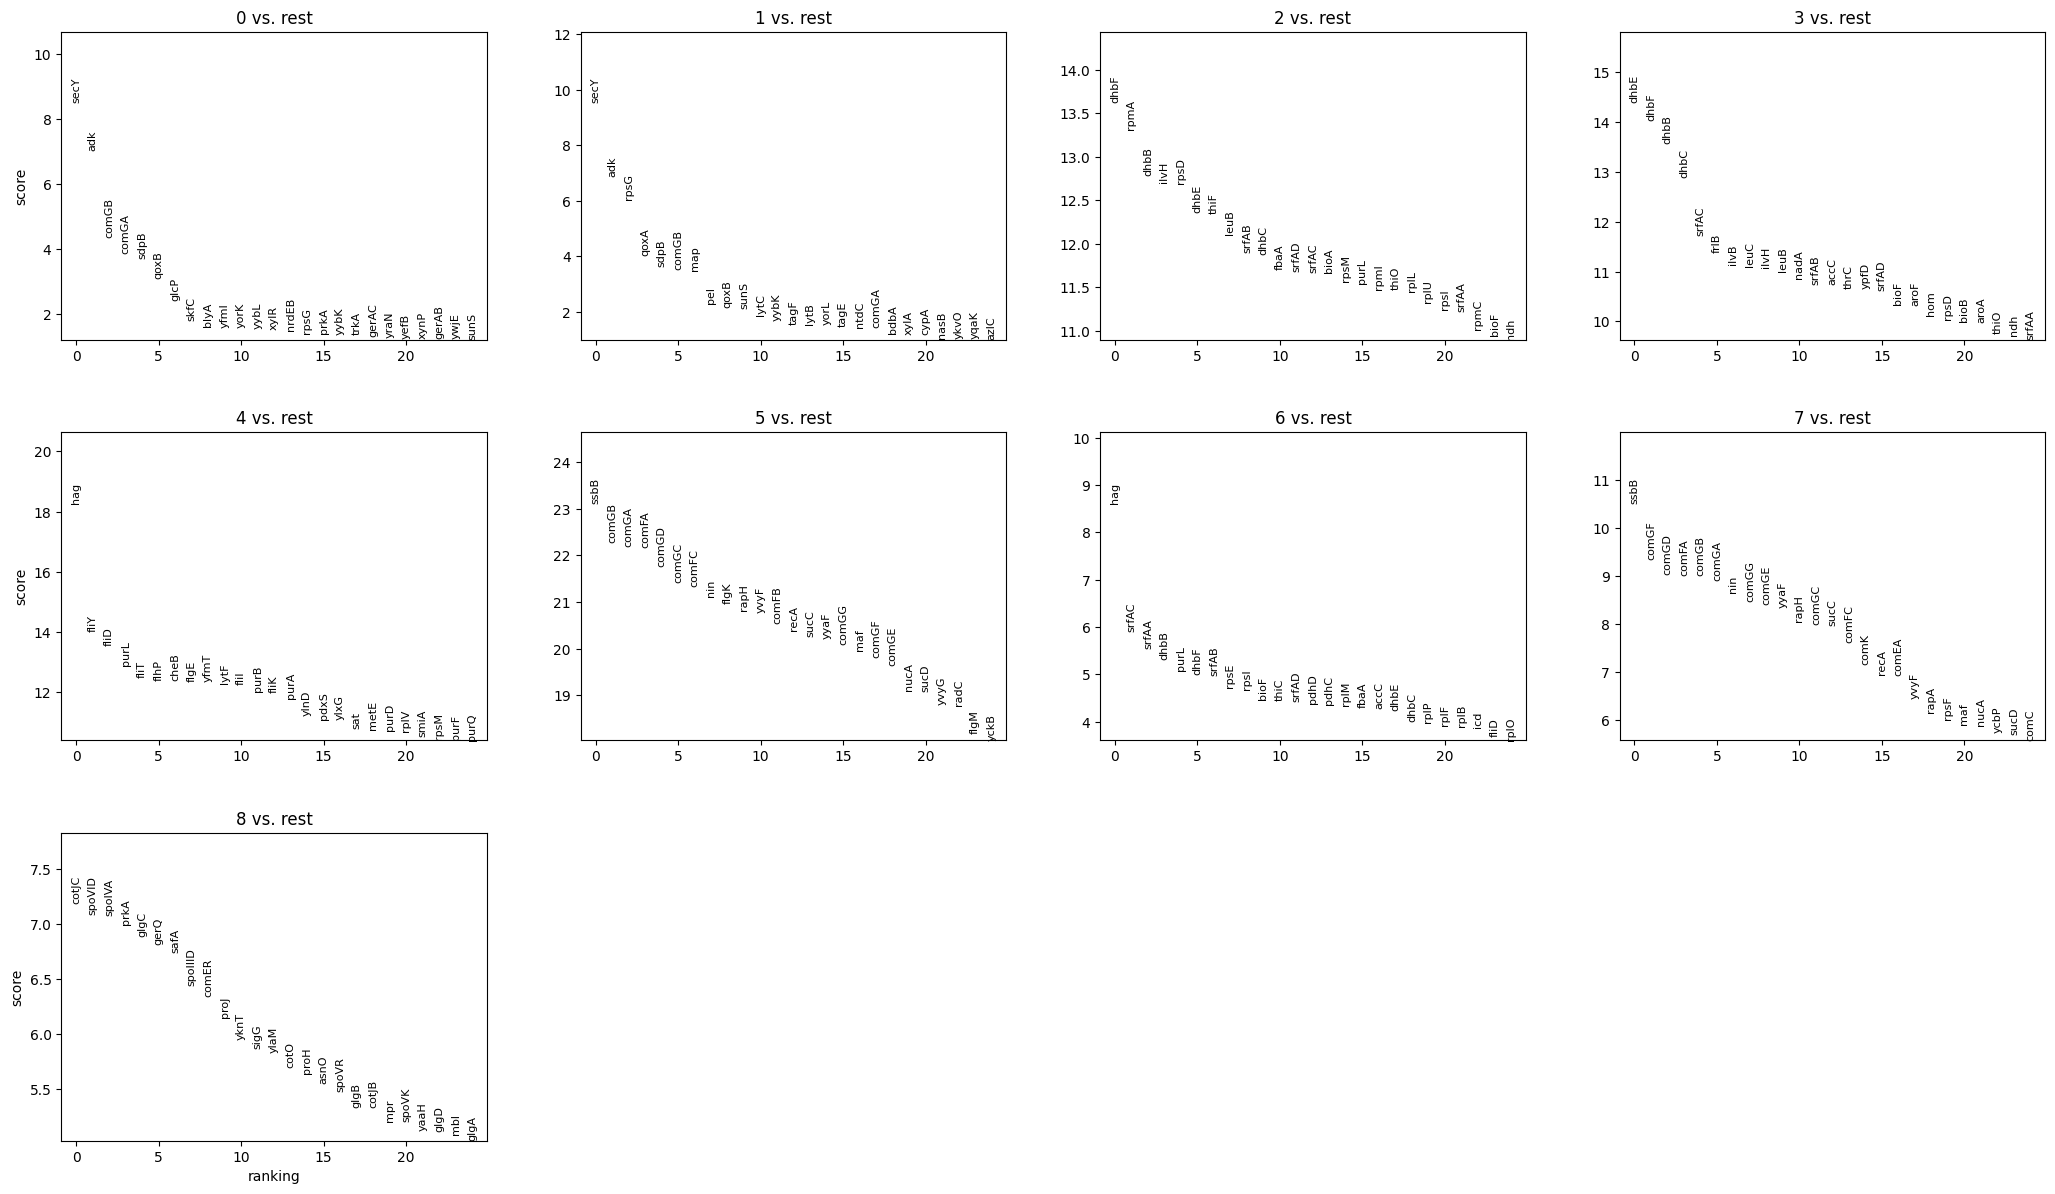

In [30]:
sc.tl.rank_genes_groups(data_gene, 'leiden_new', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

In [39]:
top_genes = [x[7] for x in data_gene.uns["rank_genes_groups"]["names"]]
print(data_gene.var.loc[top_genes[:25], ["Locus tag", "Protein accession", "Name", "Symbol"]])


       Locus tag Protein accession  \
index                                
ssbB   BSU_36310       NP_391512.2   
comGF  BSU_24680       NP_390348.1   
comGD  BSU_24700       NP_390350.1   
comFA  BSU_35470       NP_391427.1   
comGB  BSU_24720       NP_390352.1   
comGA  BSU_24730       NP_390353.1   
nin    BSU_03420       NP_388224.1   
comGG  BSU_24670       NP_390347.1   
comGE  BSU_24690       NP_390349.1   
yyaF         NaN               NaN   
rapH   BSU_06830       NP_388565.2   
comGC  BSU_24710       NP_390351.1   
sucC   BSU_16090       NP_389491.1   
comFC  BSU_35450       NP_391425.2   
comK   BSU_10420       NP_388923.1   
recA   BSU_16940       NP_389576.2   
comEA  BSU_25590       NP_390437.1   
yvyF   BSU_35440       NP_391424.1   
rapA   BSU_12430       NP_389125.1   
rpsF   BSU_40910       NP_391971.1   
maf    BSU_28050       NP_390683.1   
nucA   BSU_03430       NP_388225.3   
ycbP   BSU_02590       NP_388141.1   
sucD   BSU_16100       NP_389492.1   
comC   BSU_2

In [24]:
data_gene.write(data_path + "/filtered_data_maxpool_processed.h5ad")

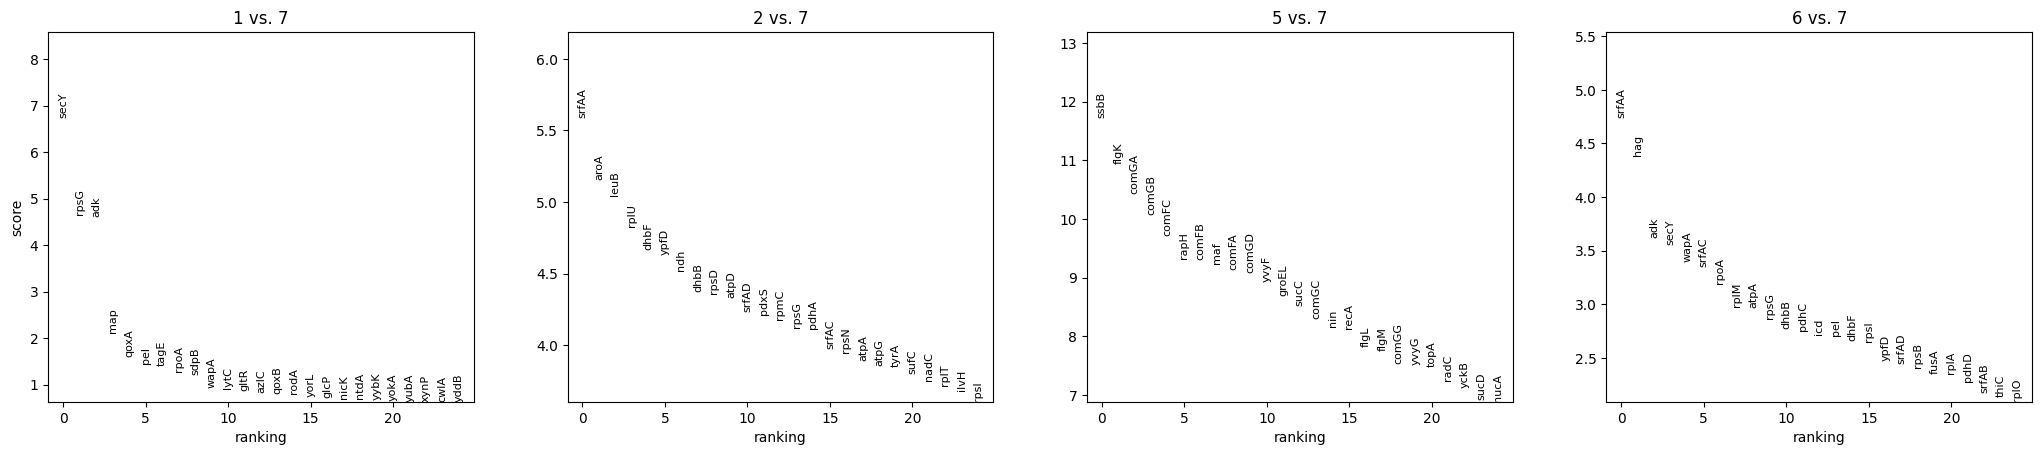

In [42]:
sc.tl.rank_genes_groups(data_gene, 'leiden_new', method='wilcoxon', groups=['1', '2', '5', '6'], reference='7')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

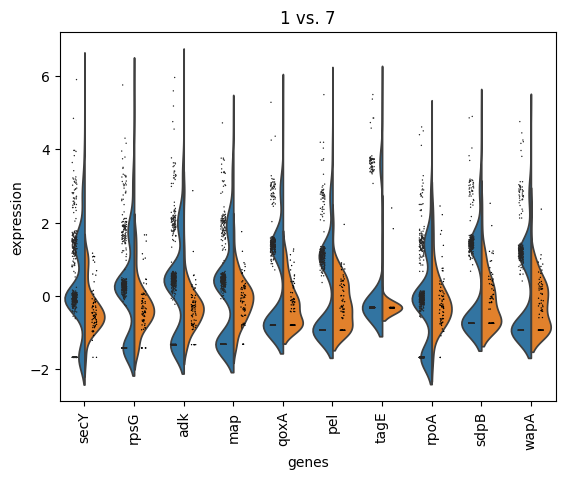

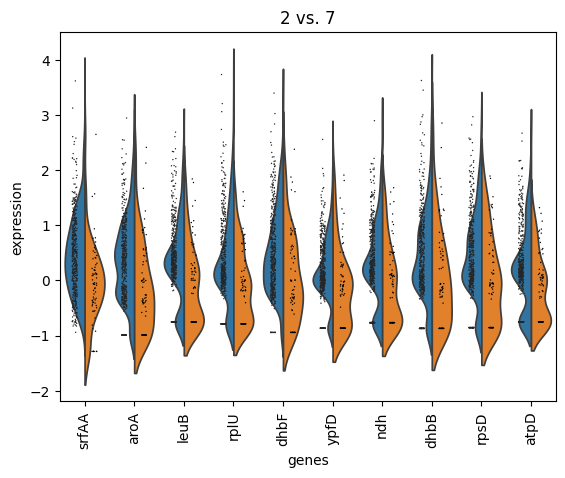

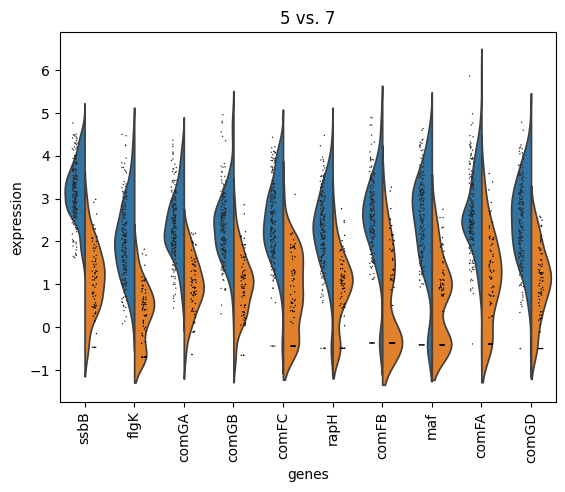

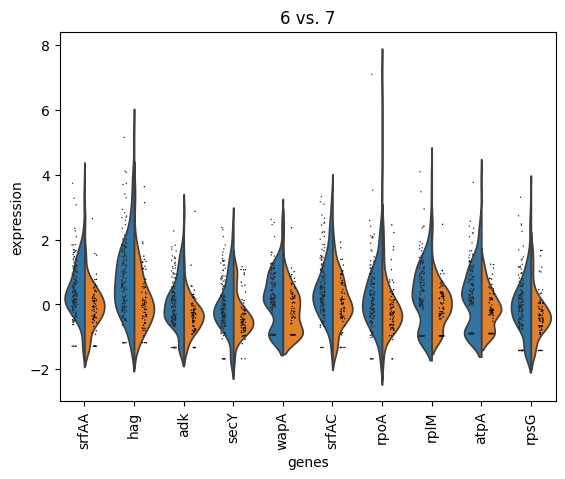

In [47]:
sc.pl.rank_genes_groups_violin(data_gene, n_genes=10)

In [48]:
top_genes = [x[1] for x in data_gene.uns["rank_genes_groups"]["names"]]
print(data_gene.var.loc[top_genes[:25], ["Locus tag", "Protein accession", "Name", "Symbol"]])


       Locus tag Protein accession  \
index                                
srfAA  BSU_03480       NP_388230.2   
aroA   BSU_22600       NP_390141.1   
leuB   BSU_28270       NP_390705.2   
rplU   BSU_27960       NP_390674.1   
dhbF   BSU_31960       NP_391076.3   
ypfD         NaN               NaN   
ndh    BSU_12290       NP_389111.1   
dhbB   BSU_31970       NP_391077.1   
rpsD   BSU_29660       NP_390844.1   
atpD   BSU_36810       NP_391562.1   
srfAD  BSU_03520       NP_388234.1   
pdxS   BSU_00110       NP_387892.1   
rpmC   BSU_01240       NP_388005.1   
rpsG   BSU_01110       NP_387992.2   
pdhA   BSU_14580       NP_389341.1   
srfAC  BSU_03510       NP_388233.2   
rpsN         NaN               NaN   
atpA   BSU_36830       NP_391564.1   
atpG   BSU_36820       NP_391563.1   
tyrA   BSU_22610       NP_390142.1   
sufC   BSU_32710       NP_391150.1   
nadC   BSU_27860       NP_390664.1   
rplT   BSU_28850       NP_390763.1   
ilvH   BSU_28300       NP_390708.2   
rpsI   BSU_0